In [1]:
import numpy as np
import pandas as pd
import random
from pylab import *
import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')

import scipy.sparse as sparse

In [2]:
from tqdm import tqdm
import pickle

In [3]:
orders = pd.read_csv('orders.csv')

order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')


In [4]:
def get_user_product_prior(orders, order_products_prior):
    order_user_prior = orders.loc[orders.eval_set == 'prior']
    order_user_prior = order_user_prior[['order_id', 'user_id']]
    df_temp = pd.merge(order_user_prior, order_products_prior[['order_id', 'product_id']], on='order_id')
    user_product_prior = df_temp[['user_id', 'product_id']]
    user_product_prior = user_product_prior.groupby(['user_id', 'product_id']).size().reset_index().rename(columns={0: 'quantity'})
    return user_product_prior

In [5]:
def get_user_product_validation(orders, order_products_train):
    order_user_train = orders.loc[orders.eval_set == 'train']
    order_user_train = order_user_train[['order_id', 'user_id']]
    df_temp = pd.merge(order_user_train, order_products_train[['order_id', 'product_id']], on='order_id')
    user_product_train = df_temp[['user_id', 'product_id']]
    user_product_train = user_product_train.groupby(['user_id', 'product_id']).size().reset_index().rename(columns={0: 'quantity'})
    return user_product_train

In [6]:
user_product_prior = get_user_product_prior(orders, order_products_prior)

In [7]:
user_product_validation = get_user_product_validation(orders, order_products_train)

In [8]:
user_product_prior.nunique()

user_id       206209
product_id     49677
quantity          99
dtype: int64

In [9]:
user_product_validation.nunique()

user_id       131209
product_id     39123
quantity           1
dtype: int64

## PMF with SGD 

https://github.com/XiuzeZhou/SGD-PMF/tree/master/SGD_PMF


In [10]:
def get_user_item_dict(user_product_prior):
    all_user_id = user_product_prior.user_id.unique()
    all_item_id = user_product_prior.product_id.unique()

    user_dict = {all_user_id[i]:i for i in range(len(all_user_id))}
    item_dict = {all_item_id[i]:i for i in range(len(all_item_id))}
    return user_dict, item_dict

In [11]:
user_dict, item_dict = get_user_item_dict(user_product_prior)

In [12]:
def map_user_product_df(user_product_prior, user_dict, item_dict):
    user_product_prior.user_id = user_product_prior.user_id.map(user_dict)
    user_product_prior.product_id = user_product_prior.product_id.map(item_dict)
    return user_product_prior

In [13]:
user_product_prior = map_user_product_df(user_product_prior, user_dict, item_dict)
user_product_validation = map_user_product_df(user_product_validation, user_dict, item_dict)

In [67]:
user_product_prior

,user_id,product_id,quantity
0,0,0,0.091837
1,0,1,0.081633
2,0,2,0.000000
3,0,3,0.091837
4,0,4,0.020408
...,...,...,...
13307948,206208,145,0.020408
13307949,206208,6285,0.000000
13307950,206208,4737,0.000000
13307951,206208,448,0.000000


In [15]:
user_product_validation

,user_id,product_id,quantity
0,0,0.0,1
1,0,1.0,1
2,0,4.0,1
3,0,8.0,1
4,0,9.0,1
...,...,...,...
1384612,206208,72.0,1
1384613,206208,5550.0,1
1384614,206208,2448.0,1
1384615,206208,9434.0,1


In [16]:
user_product_validation = user_product_validation.dropna()

In [17]:
user_product_validation.isnull().sum()

user_id       0
product_id    0
quantity      0
dtype: int64

In [18]:
def get_user_product_normalized(user_product_prior):
    max_quantity = user_product_prior['quantity'].max()
    user_product_prior['quantity'] = user_product_prior['quantity'].apply(lambda x: (x-1)/(max_quantity-1))
    return user_product_prior

In [19]:
user_product_prior_normalized = get_user_product_normalized(user_product_prior)

In [20]:
user_product_prior_normalized

,user_id,product_id,quantity
0,0,0,0.091837
1,0,1,0.081633
2,0,2,0.000000
3,0,3,0.091837
4,0,4,0.020408
...,...,...,...
13307948,206208,145,0.020408
13307949,206208,6285,0.000000
13307950,206208,4737,0.000000
13307951,206208,448,0.000000


In [21]:
def logistic_fn(x):
    '''
    a logistic used to normalize feature vector product
    '''
    return 1/(1 + np.exp(-x))

In [107]:
def logistic_fn_dev(x):
    '''
    a logistic derivative
    '''
    return np.exp(x)/((1+np.exp(x))**2)

In [ ]:
class PMF_V1():
    def __init__(self, 
                 train_set,            # train_set dtype: df
                 validation_set,       # validation_set dtype: df     
                 N,                    # number of users: int 
                 M,                    # number of products: int 
                 K,                    # number of latent factors: int
                 eta,                  # learning rate
                 lbd,                  # regularization para
                 epoch                 # number of epoch
                ):
        self.train_set = train_set
        self.validation_set = validation_set
        self.N = N
        self.M = M
        self.K = K
        self.eta = eta
        self.lbd = lbd
        self.epoch = epoch
    
    
    def train(self):
        np.random.seed(421) ; U = np.random.normal(0, 0.1, (self.N, self.K))
        np.random.seed(421) ; V = np.random.normal(0, 0.1, (self.M, self.K))
        
        train_set_np = self.train_set.to_numpy()
        validation_set_np = self.validation_set.to_numpy()
        
        L = 1000.0
        RMSE = []
        LOSS = []

        for step in tqdm(range(self.epoch)):
            loss = 0.0
            for data in train_set_np:
                u = int(data[0])
                i = int(data[1])
                r = data[2]

                e = r - logistic_fn(np.dot(U[u], V[i].T))           
                U[u] = U[u] + self.eta*(e*logistic_fn_dev(np.dot(U[u], V[i].T))*V[i] - self.lbd*U[u])
                V[i] = V[i] + self.eta*(e*logistic_fn_dev(np.dot(U[u], V[i].T))*U[u] - self.lbd*V[i])

                loss += 0.5*(e**2 + self.lbd*(np.linalg.norm(U[u]) + np.linalg.norm(V[i])))
            LOSS.append(loss)
            rmse_iter = self.get_rmse_val(validation_set_np, U, V)
            RMSE.append(rmse_iter)
            print(LOSS)
            print(RMSE)
            if loss < L:
                break
        return RMSE, LOSS, U, V
     
    def get_rmse_val(self, validation_set_np, U, V):
        rmse = 0.0
        for data in validation_set_np:
            u = int(data[0])
            i = int(data[1])
            r = data[2]
            e = r - logistic_fn(np.dot(U[u], V[i].T))
            rmse += np.square(e)
        return np.sqrt(rmse/len(validation_set_np))
        

    def prediction(self, P, Q):
        N,K = P.shape
        M,K = Q.shape

        rating_list=[]
        for u in range(N):
            u_rating = np.sum(P[u,:]*Q, axis=1)
            rating_list.append(u_rating)
        r_pred = np.array(rating_list)
        return r_pred

In [111]:
class PMF_V2():
    def __init__(self, 
                 train_set,            # train_set dtype: df
                 validation_set,       # validation_set dtype: df     
                 N,                    # number of users: int 
                 M,                    # number of products: int 
                 K,                    # number of latent factors: int
                 eta,                  # learning rate
                 lbd,                  # regularization para
                 epoch                 # number of epoch
                ):
        self.train_set = train_set
        self.validation_set = validation_set
        self.N = N
        self.M = M
        self.K = K
        self.eta = eta
        self.lbd = lbd
        self.epoch = epoch
    
    
    def train(self):
        np.random.seed(421) ; U = np.random.normal(0, 0.1, (self.N, self.K))
        np.random.seed(421) ; V = np.random.normal(0, 0.1, (self.M, self.K))
        
        train_set_np = self.train_set.to_numpy()
        validation_set_np = self.validation_set.to_numpy()
        
        L = 1000.0
#         RMSE = []
        LOSS = []

        for step in tqdm(range(self.epoch)):
            loss = 0.0
            for data in train_set_np:
                u = int(data[0])
                i = int(data[1])
                r = data[2]

                e = r - logistic_fn(np.dot(U[u], V[i].T))           
                U[u] = U[u] + self.eta*(e*logistic_fn_dev(np.dot(U[u], V[i].T))*V[i] - self.lbd*U[u])
                V[i] = V[i] + self.eta*(e*logistic_fn_dev(np.dot(U[u], V[i].T))*U[u] - self.lbd*V[i])

                loss += 0.5*(e**2 + self.lbd*(np.linalg.norm(U[u]) + np.linalg.norm(V[i])))
            LOSS.append(loss)
#             rmse_iter = self.get_rmse_val(validation_set_np, U, V)
#             RMSE.append(rmse_iter)
            print(LOSS)
#             print(RMSE)
            if loss < L:
                break
        return LOSS, U, V
     
#     def get_rmse_val(self, validation_set_np, U, V):
#         rmse = 0.0
#         for data in validation_set_np:
#             u = int(data[0])
#             i = int(data[1])
#             r = data[2] - 1
#             e = r - logistic_fn(np.dot(U[u], V[i].T))
#             rmse += np.square(e)
#         return np.sqrt(rmse/len(validation_set_np))
        
    def avg_precision(self, actual, predicted):
        score = 0.0
        num_hits = 0.0
        
        for i, p in enumerate(predicted):
            if p in actual and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)
        if num_hits == 0.0:
            return 0.0
        return score / num_hits
    
    def prediction_map(self, U, V):
        scores = []
        for u in tqdm(range(len(U))):
            user_item_score = np.matmul(U[u], V.T)
            recomm_items = np.argsort(user_item_score)[-1:-11:-1]

            gt_product = self.validation_set.query('user_id=={}'.format(u)).product_id.values
            score = self.avg_precision(gt_product, recomm_items)
            scores.append(score)

            if u > 0 and u % 10000 == 0:
                break
        return np.mean(scores)

In [121]:
test_2 = PMF_V2(user_product_prior_normalized, user_product_validation, N = 206209, M = 49677, K = 30, eta = 0.1,
                 lbd = 0.01, epoch = 20)

In [122]:
RMSE_2, LOSS_2, U_2, V_2 = test_2.train()

 10%|█         | 2/20 [21:31<3:13:03, 643.55s/it]

[1439110.3976564142, 763928.0561167707]
[0.4337944265983535, 0.2662465896270365]


 15%|█▌        | 3/20 [32:04<3:01:21, 640.11s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123]


 20%|██        | 4/20 [42:52<2:51:21, 642.60s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851]


 25%|██▌       | 5/20 [53:50<2:41:49, 647.30s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945]


 30%|███       | 6/20 [1:03:55<2:28:03, 634.52s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778]


 35%|███▌      | 7/20 [1:14:57<2:19:16, 642.77s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313, 297059.2033158287]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778, 0.14782762672885336]


 40%|████      | 8/20 [1:25:14<2:07:02, 635.17s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313, 297059.2033158287, 289688.5300440497]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778, 0.14782762672885336, 0.14236303463857047]


 45%|████▌     | 9/20 [1:36:13<1:57:43, 642.14s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313, 297059.2033158287, 289688.5300440497, 284540.1527809797]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778, 0.14782762672885336, 0.14236303463857047, 0.13815992528658733]


 50%|█████     | 10/20 [1:46:50<1:46:47, 640.77s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313, 297059.2033158287, 289688.5300440497, 284540.1527809797, 280787.54759706184]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778, 0.14782762672885336, 0.14236303463857047, 0.13815992528658733, 0.1348424259091947]


 55%|█████▌    | 11/20 [1:57:28<1:35:57, 639.68s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313, 297059.2033158287, 289688.5300440497, 284540.1527809797, 280787.54759706184, 277961.5964972108]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778, 0.14782762672885336, 0.14236303463857047, 0.13815992528658733, 0.1348424259091947, 0.1321705300136543]


 60%|██████    | 12/20 [2:08:12<1:25:28, 641.03s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313, 297059.2033158287, 289688.5300440497, 284540.1527809797, 280787.54759706184, 277961.5964972108, 275777.7299468888]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778, 0.14782762672885336, 0.14236303463857047, 0.13815992528658733, 0.1348424259091947, 0.1321705300136543, 0.12998330652286705]


 65%|██████▌   | 13/20 [2:19:00<1:15:01, 643.08s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313, 297059.2033158287, 289688.5300440497, 284540.1527809797, 280787.54759706184, 277961.5964972108, 275777.7299468888, 274054.15942672105]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778, 0.14782762672885336, 0.14236303463857047, 0.13815992528658733, 0.1348424259091947, 0.1321705300136543, 0.12998330652286705, 0.1281686062593849]


 70%|███████   | 14/20 [2:29:50<1:04:32, 645.41s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313, 297059.2033158287, 289688.5300440497, 284540.1527809797, 280787.54759706184, 277961.5964972108, 275777.7299468888, 274054.15942672105, 272669.8406224169]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778, 0.14782762672885336, 0.14236303463857047, 0.13815992528658733, 0.1348424259091947, 0.1321705300136543, 0.12998330652286705, 0.1281686062593849, 0.12664580711251078]


 75%|███████▌  | 15/20 [2:40:38<53:50, 646.04s/it]  

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313, 297059.2033158287, 289688.5300440497, 284540.1527809797, 280787.54759706184, 277961.5964972108, 275777.7299468888, 274054.15942672105, 272669.8406224169, 271541.39180688624]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778, 0.14782762672885336, 0.14236303463857047, 0.13815992528658733, 0.1348424259091947, 0.1321705300136543, 0.12998330652286705, 0.1281686062593849, 0.12664580711251078, 0.1253554508764368]


 80%|████████  | 16/20 [2:51:23<43:02, 645.61s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313, 297059.2033158287, 289688.5300440497, 284540.1527809797, 280787.54759706184, 277961.5964972108, 275777.7299468888, 274054.15942672105, 272669.8406224169, 271541.39180688624, 270609.72407488443]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778, 0.14782762672885336, 0.14236303463857047, 0.13815992528658733, 0.1348424259091947, 0.1321705300136543, 0.12998330652286705, 0.1281686062593849, 0.12664580711251078, 0.1253554508764368, 0.12425274103385771]


 85%|████████▌ | 17/20 [3:02:23<32:29, 649.96s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313, 297059.2033158287, 289688.5300440497, 284540.1527809797, 280787.54759706184, 277961.5964972108, 275777.7299468888, 274054.15942672105, 272669.8406224169, 271541.39180688624, 270609.72407488443, 269831.94584437873]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778, 0.14782762672885336, 0.14236303463857047, 0.13815992528658733, 0.1348424259091947, 0.1321705300136543, 0.12998330652286705, 0.1281686062593849, 0.12664580711251078, 0.1253554508764368, 0.12425274103385771, 0.12330331081801724]


 90%|█████████ | 18/20 [3:13:08<21:36, 648.44s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313, 297059.2033158287, 289688.5300440497, 284540.1527809797, 280787.54759706184, 277961.5964972108, 275777.7299468888, 274054.15942672105, 272669.8406224169, 271541.39180688624, 270609.72407488443, 269831.94584437873, 269176.27412895707]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778, 0.14782762672885336, 0.14236303463857047, 0.13815992528658733, 0.1348424259091947, 0.1321705300136543, 0.12998330652286705, 0.1281686062593849, 0.12664580711251078, 0.1253554508764368, 0.12425274103385771, 0.12330331081801724, 0.12248038193701945]


 95%|█████████▌| 19/20 [3:23:30<10:40, 640.56s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313, 297059.2033158287, 289688.5300440497, 284540.1527809797, 280787.54759706184, 277961.5964972108, 275777.7299468888, 274054.15942672105, 272669.8406224169, 271541.39180688624, 270609.72407488443, 269831.94584437873, 269176.27412895707, 268618.7318853487]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778, 0.14782762672885336, 0.14236303463857047, 0.13815992528658733, 0.1348424259091947, 0.1321705300136543, 0.12998330652286705, 0.1281686062593849, 0.12664580711251078, 0.1253554508764368, 0.12425274103385771, 0.12330331081801724, 0.12248038193701945, 0.12176280547125776]


100%|██████████| 20/20 [3:34:37<00:00, 643.89s/it]

[1439110.3976564142, 763928.0561167707, 446280.3687232512, 361635.89029701735, 326714.6639481237, 308243.65298281313, 297059.2033158287, 289688.5300440497, 284540.1527809797, 280787.54759706184, 277961.5964972108, 275777.7299468888, 274054.15942672105, 272669.8406224169, 271541.39180688624, 270609.72407488443, 269831.94584437873, 269176.27412895707, 268618.7318853487, 268140.94446496054]
[0.4337944265983535, 0.2662465896270365, 0.20835017618497123, 0.1813365177847851, 0.16556605094914945, 0.1551811732968778, 0.14782762672885336, 0.14236303463857047, 0.13815992528658733, 0.1348424259091947, 0.1321705300136543, 0.12998330652286705, 0.1281686062593849, 0.12664580711251078, 0.1253554508764368, 0.12425274103385771, 0.12330331081801724, 0.12248038193701945, 0.12176280547125776, 0.12113367954651603]


In [126]:
MAP_2 = test_2.prediction_map(U_2, V_2)

  5%|▍         | 10000/206209 [09:45<3:11:28, 17.08it/s]


In [127]:
MAP_2

0.0

In [123]:
test_3 = PMF_V2(user_product_prior_normalized, user_product_validation, N = 206209, M = 49677, K = 40, eta = 0.1,
                 lbd = 0.01, epoch = 30)

In [124]:
RMSE_3, LOSS_3, U_3, V_3 = test_3.train()

  3%|▎         | 1/30 [11:01<5:19:46, 661.59s/it]

[1430603.5435018882]
[0.4287895034028563]


  7%|▋         | 2/30 [22:01<5:08:32, 661.15s/it]

[1430603.5435018882, 750964.6266716269]
[0.4287895034028563, 0.263459075676604]


 10%|█         | 3/30 [33:02<4:57:32, 661.19s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714]


 13%|█▎        | 4/30 [43:55<4:45:21, 658.53s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633]


 17%|█▋        | 5/30 [55:23<4:38:01, 667.28s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203]


 20%|██        | 6/30 [1:06:52<4:29:34, 673.93s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278]


 23%|██▎       | 7/30 [1:17:33<4:14:36, 664.18s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085]


 27%|██▋       | 8/30 [1:28:20<4:01:34, 658.86s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528]


 30%|███       | 9/30 [1:39:15<3:50:15, 657.86s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585]


 33%|███▎      | 10/30 [1:49:31<3:35:03, 645.20s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515]


 37%|███▋      | 11/30 [2:00:18<3:24:30, 645.83s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808]


 40%|████      | 12/30 [2:11:10<3:14:18, 647.69s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742]


 43%|████▎     | 13/30 [2:22:11<3:04:37, 651.60s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784]


 47%|████▋     | 14/30 [2:32:51<2:52:50, 648.18s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398]


 50%|█████     | 15/30 [2:44:00<2:43:35, 654.40s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747]


 53%|█████▎    | 16/30 [2:54:59<2:32:59, 655.70s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444]


 57%|█████▋    | 17/30 [3:05:51<2:21:51, 654.73s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444, 0.12332188141039944]


 60%|██████    | 18/30 [3:16:51<2:11:13, 656.13s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697, 269483.84655698907]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444, 0.12332188141039944, 0.12250033674769661]


 63%|██████▎   | 19/30 [3:27:44<2:00:08, 655.28s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697, 269483.84655698907, 268904.8407116806]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444, 0.12332188141039944, 0.12250033674769661, 0.12178366338185052]


 67%|██████▋   | 20/30 [3:38:55<1:49:59, 659.92s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697, 269483.84655698907, 268904.8407116806, 268407.63574607583]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444, 0.12332188141039944, 0.12250033674769661, 0.12178366338185052, 0.12115507603472296]


 70%|███████   | 21/30 [3:49:37<1:38:10, 654.51s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697, 269483.84655698907, 268904.8407116806, 268407.63574607583, 267977.7137686066]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444, 0.12332188141039944, 0.12250033674769661, 0.12178366338185052, 0.12115507603472296, 0.12060101230168364]


 73%|███████▎  | 22/30 [4:00:39<1:27:35, 656.96s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697, 269483.84655698907, 268904.8407116806, 268407.63574607583, 267977.7137686066, 267603.6329847235]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444, 0.12332188141039944, 0.12250033674769661, 0.12178366338185052, 0.12115507603472296, 0.12060101230168364, 0.1201104112622497]


 77%|███████▋  | 23/30 [4:12:00<1:17:28, 664.03s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697, 269483.84655698907, 268904.8407116806, 268407.63574607583, 267977.7137686066, 267603.6329847235, 267276.27553181327]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444, 0.12332188141039944, 0.12250033674769661, 0.12178366338185052, 0.12115507603472296, 0.12060101230168364, 0.1201104112622497, 0.11967417621253762]


 80%|████████  | 24/30 [4:23:09<1:06:32, 665.49s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697, 269483.84655698907, 268904.8407116806, 268407.63574607583, 267977.7137686066, 267603.6329847235, 267276.27553181327, 266988.30242146994]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444, 0.12332188141039944, 0.12250033674769661, 0.12178366338185052, 0.12115507603472296, 0.12060101230168364, 0.1201104112622497, 0.11967417621253762, 0.11928476891913987]


 83%|████████▎ | 25/30 [4:33:57<55:02, 660.44s/it]  

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697, 269483.84655698907, 268904.8407116806, 268407.63574607583, 267977.7137686066, 267603.6329847235, 267276.27553181327, 266988.30242146994, 266733.7525586916]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444, 0.12332188141039944, 0.12250033674769661, 0.12178366338185052, 0.12115507603472296, 0.12060101230168364, 0.1201104112622497, 0.11967417621253762, 0.11928476891913987, 0.1189358993494

 87%|████████▋ | 26/30 [4:45:07<44:12, 663.17s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697, 269483.84655698907, 268904.8407116806, 268407.63574607583, 267977.7137686066, 267603.6329847235, 267276.27553181327, 266988.30242146994, 266733.7525586916, 266507.7437028977]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444, 0.12332188141039944, 0.12250033674769661, 0.12178366338185052, 0.12115507603472296, 0.12060101230168364, 0.1201104112622497, 0.11967417621253762, 0.119284768919139

 90%|█████████ | 27/30 [4:56:03<33:02, 660.93s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697, 269483.84655698907, 268904.8407116806, 268407.63574607583, 267977.7137686066, 267603.6329847235, 267276.27553181327, 266988.30242146994, 266733.7525586916, 266507.7437028977, 266306.2466705807]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444, 0.12332188141039944, 0.12250033674769661, 0.12178366338185052, 0.12115507603472296, 0.12060101230168364, 0.1201104112622497, 0.11967417621253762

 93%|█████████▎| 28/30 [5:07:51<22:30, 675.20s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697, 269483.84655698907, 268904.8407116806, 268407.63574607583, 267977.7137686066, 267603.6329847235, 267276.27553181327, 266988.30242146994, 266733.7525586916, 266507.7437028977, 266306.2466705807, 266125.9129010787]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444, 0.12332188141039944, 0.12250033674769661, 0.12178366338185052, 0.12115507603472296, 0.12060101230168364, 0.1201104112622497, 

 97%|█████████▋| 29/30 [5:19:19<11:18, 678.95s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697, 269483.84655698907, 268904.8407116806, 268407.63574607583, 267977.7137686066, 267603.6329847235, 267276.27553181327, 266988.30242146994, 266733.7525586916, 266507.7437028977, 266306.2466705807, 266125.9129010787, 265963.94139938825]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444, 0.12332188141039944, 0.12250033674769661, 0.12178366338185052, 0.12115507603472296, 0.12060101230168364, 

100%|██████████| 30/30 [5:32:02<00:00, 664.09s/it]

[1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697, 269483.84655698907, 268904.8407116806, 268407.63574607583, 267977.7137686066, 267603.6329847235, 267276.27553181327, 266988.30242146994, 266733.7525586916, 266507.7437028977, 266306.2466705807, 266125.9129010787, 265963.94139938825, 265817.9750784928]
[0.4287895034028563, 0.263459075676604, 0.20722734951901714, 0.18075927459888633, 0.16523093780966203, 0.15497438060738278, 0.14769657954319085, 0.14227989238190528, 0.13810851977292585, 0.1348127356268515, 0.13215603820159808, 0.12997961784097742, 0.12817267044075784, 0.12665545886369398, 0.12536912496367747, 0.12426928936571444, 0.12332188141039944, 0.12250033674769661, 0.12178366338185052, 0.12115507603472296, 0.

In [128]:
MAP_3 = test_3.prediction_map(U_3, V_3)

  5%|▍         | 10000/206209 [05:40<1:51:19, 29.37it/s]


In [129]:
MAP_3

0.0

In [89]:
test = PMF_V2(user_product_prior_normalized, user_product_validation, N = 206209, M = 49677, K = 20, eta = 0.01,
                 lbd = 0.001, epoch = 30)

In [27]:
RMSE, LOSS, U, V = test.train()

  3%|▎         | 1/30 [09:42<4:41:36, 582.65s/it]

[1532103.8571076144]
[0.5372149181885859]


  7%|▋         | 2/30 [19:50<4:35:27, 590.29s/it]

[1532103.8571076144, 1071920.32418644]
[0.5372149181885859, 0.725383162290132]


 10%|█         | 3/30 [29:55<4:27:32, 594.55s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667]


 13%|█▎        | 4/30 [39:08<4:12:16, 582.18s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941]


 17%|█▋        | 5/30 [48:24<3:59:15, 574.24s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377]


 20%|██        | 6/30 [57:42<3:47:47, 569.46s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697]


 23%|██▎       | 7/30 [1:06:59<3:36:53, 565.78s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784]


 27%|██▋       | 8/30 [1:15:51<3:23:40, 555.48s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713]


 30%|███       | 9/30 [1:24:41<3:11:49, 548.06s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235]


 33%|███▎      | 10/30 [1:32:51<2:56:48, 530.43s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112]


 37%|███▋      | 11/30 [1:41:38<2:47:42, 529.62s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356]


 40%|████      | 12/30 [1:51:13<2:42:55, 543.08s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679]


 43%|████▎     | 13/30 [2:00:08<2:33:12, 540.74s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626]


 47%|████▋     | 14/30 [2:09:10<2:24:18, 541.18s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959]


 50%|█████     | 15/30 [2:18:13<2:15:24, 541.62s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618]


 53%|█████▎    | 16/30 [2:26:45<2:04:17, 532.64s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696]


 57%|█████▋    | 17/30 [2:35:24<1:54:29, 528.46s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214, 51999.45165766609]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696, 0.9684287077393944]


 60%|██████    | 18/30 [2:44:20<1:46:11, 530.94s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214, 51999.45165766609, 50497.85646113928]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696, 0.9684287077393944, 0.9694555514670269]


 63%|██████▎   | 19/30 [2:53:22<1:37:57, 534.30s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214, 51999.45165766609, 50497.85646113928, 49212.98939197817]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696, 0.9684287077393944, 0.9694555514670269, 0.9703602874717342]


 67%|██████▋   | 20/30 [3:02:01<1:28:16, 529.67s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214, 51999.45165766609, 50497.85646113928, 49212.98939197817, 48103.93626278575]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696, 0.9684287077393944, 0.9694555514670269, 0.9703602874717342, 0.971163058703735]


 70%|███████   | 21/30 [3:10:32<1:18:36, 524.05s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214, 51999.45165766609, 50497.85646113928, 49212.98939197817, 48103.93626278575, 47139.15381651446]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696, 0.9684287077393944, 0.9694555514670269, 0.9703602874717342, 0.971163058703735, 0.9718798362589065]


 73%|███████▎  | 22/30 [3:18:53<1:08:57, 517.20s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214, 51999.45165766609, 50497.85646113928, 49212.98939197817, 48103.93626278575, 47139.15381651446, 46293.97782553566]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696, 0.9684287077393944, 0.9694555514670269, 0.9703602874717342, 0.971163058703735, 0.9718798362589065, 0.9725234408032598]


 77%|███████▋  | 23/30 [3:27:06<59:29, 509.87s/it]  

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214, 51999.45165766609, 50497.85646113928, 49212.98939197817, 48103.93626278575, 47139.15381651446, 46293.97782553566, 45548.87738057922]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696, 0.9684287077393944, 0.9694555514670269, 0.9703602874717342, 0.971163058703735, 0.9718798362589065, 0.9725234408032598, 0.9731042786580981]


 80%|████████  | 24/30 [3:35:25<50:40, 506.67s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214, 51999.45165766609, 50497.85646113928, 49212.98939197817, 48103.93626278575, 47139.15381651446, 46293.97782553566, 45548.87738057922, 44888.2090624271]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696, 0.9684287077393944, 0.9694555514670269, 0.9703602874717342, 0.971163058703735, 0.9718798362589065, 0.9725234408032598, 0.9731042786580981, 0.973630881309679]


 83%|████████▎ | 25/30 [3:44:00<42:24, 508.95s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214, 51999.45165766609, 50497.85646113928, 49212.98939197817, 48103.93626278575, 47139.15381651446, 46293.97782553566, 45548.87738057922, 44888.2090624271, 44299.31294022978]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696, 0.9684287077393944, 0.9694555514670269, 0.9703602874717342, 0.971163058703735, 0.9718798362589065, 0.9725234408032598, 0.9731042786580981, 0.973630881309679, 0.9741103069470315]


 87%|████████▋ | 26/30 [3:52:38<34:07, 511.88s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214, 51999.45165766609, 50497.85646113928, 49212.98939197817, 48103.93626278575, 47139.15381651446, 46293.97782553566, 45548.87738057922, 44888.2090624271, 44299.31294022978, 43771.84668847877]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696, 0.9684287077393944, 0.9694555514670269, 0.9703602874717342, 0.971163058703735, 0.9718798362589065, 0.9725234408032598, 0.9731042786580981, 0.973630881309679, 0.9741103069470315, 0.97

 90%|█████████ | 27/30 [4:00:42<25:10, 503.35s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214, 51999.45165766609, 50497.85646113928, 49212.98939197817, 48103.93626278575, 47139.15381651446, 46293.97782553566, 45548.87738057922, 44888.2090624271, 44299.31294022978, 43771.84668847877, 43297.28838827883]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696, 0.9684287077393944, 0.9694555514670269, 0.9703602874717342, 0.971163058703735, 0.9718798362589065, 0.9725234408032598, 0.9731042786580981, 0.973630881309679, 0.974

 93%|█████████▎| 28/30 [4:08:33<16:27, 493.64s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214, 51999.45165766609, 50497.85646113928, 49212.98939197817, 48103.93626278575, 47139.15381651446, 46293.97782553566, 45548.87738057922, 44888.2090624271, 44299.31294022978, 43771.84668847877, 43297.28838827883, 42868.5606606388]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696, 0.9684287077393944, 0.9694555514670269, 0.9703602874717342, 0.971163058703735, 0.9718798362589065, 0.9725234408032598, 0.9731042786580981, 0.9736

 97%|█████████▋| 29/30 [4:16:52<08:15, 495.17s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214, 51999.45165766609, 50497.85646113928, 49212.98939197817, 48103.93626278575, 47139.15381651446, 46293.97782553566, 45548.87738057922, 44888.2090624271, 44299.31294022978, 43771.84668847877, 43297.28838827883, 42868.5606606388, 42479.74328836421]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696, 0.9684287077393944, 0.9694555514670269, 0.9703602874717342, 0.971163058703735, 0.9718798362589065, 0.9725234408032598, 0.97310

100%|██████████| 30/30 [4:24:47<00:00, 529.59s/it]

[1532103.8571076144, 1071920.32418644, 525240.7985522097, 295568.06126957235, 195943.41314890893, 145528.81671604517, 116548.02694297004, 98242.82368781742, 85857.71625910644, 77036.17318125207, 70499.29965502248, 65501.46063035155, 61582.32254557601, 58444.16748047488, 55886.91259843205, 53771.69162035214, 51999.45165766609, 50497.85646113928, 49212.98939197817, 48103.93626278575, 47139.15381651446, 46293.97782553566, 45548.87738057922, 44888.2090624271, 44299.31294022978, 43771.84668847877, 43297.28838827883, 42868.5606606388, 42479.74328836421, 42125.85118614765]
[0.5372149181885859, 0.725383162290132, 0.8321750807647667, 0.8822330818415941, 0.9093487449424377, 0.9257812940023697, 0.9366195371944784, 0.9442314837649713, 0.9498382468840235, 0.9541236947006112, 0.9574966670851356, 0.9602151852791679, 0.9624495492100626, 0.9643163663465959, 0.9658979616878618, 0.9672539974023696, 0.9684287077393944, 0.9694555514670269, 0.9703602874717342, 0.971163058703735, 0.9718798362589065, 0.972523

In [105]:
u_scores = np.matmul(U[88], V.T)
sorted_idx = np.argsort(u_scores)[-1:-11:-1]
sorted_idx, user_product_validation.query('user_id==88')

(array([46989, 45390, 47675, 49474, 44973, 48521, 47568, 48992, 48718,
        40130]),
      user_id  product_id  quantity
 568       88      7542.0         1
 569       88      1010.0         1
 570       88      2780.0         1
 571       88      1697.0         1
 572       88        57.0         1
 573       88      2757.0         1
 574       88      1014.0         1
 575       88        12.0         1
 576       88      5612.0         1
 577       88      1021.0         1
 578       88      2373.0         1
 579       88       443.0         1
 580       88       388.0         1
 581       88      3276.0         1)

In [90]:
MAP = test.prediction_map(U, V)

  5%|▍         | 10000/206209 [02:28<48:38, 67.23it/s]


In [91]:
MAP

1.666500016665e-05

In [49]:
user_product_validation.query('product_id==48521')

,user_id,product_id,quantity
4338,666,48521.0,1
385204,57629,48521.0,1
1181347,175766,48521.0,1


In [106]:
# Figure(LOSS, RMSE)

In [97]:
test_2 = PMF_V2(user_product_prior_normalized, user_product_validation, N = 206209, M = 49677, K = 20, eta = 0.01,
                 lbd = 0.0001, epoch = 30)

In [98]:
RMSE, LOSS, U, V = test_2.train()

  3%|▎         | 1/30 [07:12<3:29:04, 432.55s/it]

[1519000.0954705428]
[0.47350095406356596]


  7%|▋         | 2/30 [14:41<3:24:09, 437.47s/it]

[1519000.0954705428, 1035866.9004116928]
[0.47350095406356596, 0.33564451450207944]


 10%|█         | 3/30 [22:10<3:18:27, 441.01s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082]


 13%|█▎        | 4/30 [29:36<3:11:39, 442.31s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315]


 17%|█▋        | 5/30 [37:12<3:06:01, 446.45s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747]


 20%|██        | 6/30 [44:42<2:59:02, 447.59s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733]


 23%|██▎       | 7/30 [52:36<2:54:34, 455.40s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419]


 27%|██▋       | 8/30 [1:00:23<2:48:21, 459.15s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307]


 30%|███       | 9/30 [1:07:27<2:36:57, 448.47s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304]


 33%|███▎      | 10/30 [1:14:46<2:28:33, 445.66s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637]


 37%|███▋      | 11/30 [1:22:24<2:22:18, 449.37s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366]


 40%|████      | 12/30 [1:29:44<2:13:59, 446.64s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737]


 43%|████▎     | 13/30 [1:37:30<2:08:09, 452.30s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349]


 47%|████▋     | 14/30 [1:44:54<1:59:55, 449.69s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717]


 50%|█████     | 15/30 [1:52:17<1:51:56, 447.75s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494]


 53%|█████▎    | 16/30 [1:59:48<1:44:42, 448.74s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544]


 57%|█████▋    | 17/30 [2:07:04<1:36:25, 445.02s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745, 24899.439461179532]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544, 0.05448286751860445]


 60%|██████    | 18/30 [2:14:36<1:29:25, 447.12s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745, 24899.439461179532, 23363.945259078646]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544, 0.05448286751860445, 0.05244895555565905]


 63%|██████▎   | 19/30 [2:22:10<1:22:21, 449.26s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745, 24899.439461179532, 23363.945259078646, 22047.241702634798]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544, 0.05448286751860445, 0.05244895555565905, 0.05067030012485738]


 67%|██████▋   | 20/30 [2:29:42<1:15:00, 450.07s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745, 24899.439461179532, 23363.945259078646, 22047.241702634798, 20908.636933219244]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544, 0.05448286751860445, 0.05244895555565905, 0.05067030012485738, 0.049108180788182576]


 70%|███████   | 21/30 [2:37:03<1:07:04, 447.15s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745, 24899.439461179532, 23363.945259078646, 22047.241702634798, 20908.636933219244, 19916.67812396192]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544, 0.05448286751860445, 0.05244895555565905, 0.05067030012485738, 0.049108180788182576, 0.047730195897696705]


 73%|███████▎  | 22/30 [2:44:53<1:00:33, 454.16s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745, 24899.439461179532, 23363.945259078646, 22047.241702634798, 20908.636933219244, 19916.67812396192, 19046.66313040203]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544, 0.05448286751860445, 0.05244895555565905, 0.05067030012485738, 0.049108180788182576, 0.047730195897696705, 0.04650946933272742]


 77%|███████▋  | 23/30 [2:52:14<52:30, 450.02s/it]  

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745, 24899.439461179532, 23363.945259078646, 22047.241702634798, 20908.636933219244, 19916.67812396192, 19046.66313040203, 18278.93595855991]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544, 0.05448286751860445, 0.05244895555565905, 0.05067030012485738, 0.049108180788182576, 0.047730195897696705, 0.04650946933272742, 0.045423852843863716]


 80%|████████  | 24/30 [2:59:58<45:25, 454.32s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745, 24899.439461179532, 23363.945259078646, 22047.241702634798, 20908.636933219244, 19916.67812396192, 19046.66313040203, 18278.93595855991, 17597.685453607945]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544, 0.05448286751860445, 0.05244895555565905, 0.05067030012485738, 0.049108180788182576, 0.047730195897696705, 0.04650946933272742, 0.045423852843863716, 0.04445508691808555]


 83%|████████▎ | 25/30 [3:07:16<37:27, 449.48s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745, 24899.439461179532, 23363.945259078646, 22047.241702634798, 20908.636933219244, 19916.67812396192, 19046.66313040203, 18278.93595855991, 17597.685453607945, 16990.072612888245]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544, 0.05448286751860445, 0.05244895555565905, 0.05067030012485738, 0.049108180788182576, 0.047730195897696705, 0.04650946933272742, 0.045423852843863716, 0.04445508691808555, 0.043588

 87%|████████▋ | 26/30 [3:14:20<29:27, 441.78s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745, 24899.439461179532, 23363.945259078646, 22047.241702634798, 20908.636933219244, 19916.67812396192, 19046.66313040203, 18278.93595855991, 17597.685453607945, 16990.072612888245, 16445.580891122197]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544, 0.05448286751860445, 0.05244895555565905, 0.05067030012485738, 0.049108180788182576, 0.047730195897696705, 0.04650946933272742, 0.045423852843863716, 0.0444550

 90%|█████████ | 27/30 [3:21:42<22:05, 441.88s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745, 24899.439461179532, 23363.945259078646, 22047.241702634798, 20908.636933219244, 19916.67812396192, 19046.66313040203, 18278.93595855991, 17597.685453607945, 16990.072612888245, 16445.580891122197, 15955.524685979182]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544, 0.05448286751860445, 0.05244895555565905, 0.05067030012485738, 0.049108180788182576, 0.047730195897696705, 0.04650946933272742, 0.045423852

 93%|█████████▎| 28/30 [3:28:39<14:28, 434.35s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745, 24899.439461179532, 23363.945259078646, 22047.241702634798, 20908.636933219244, 19916.67812396192, 19046.66313040203, 18278.93595855991, 17597.685453607945, 16990.072612888245, 16445.580891122197, 15955.524685979182, 15512.67390916732]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544, 0.05448286751860445, 0.05244895555565905, 0.05067030012485738, 0.049108180788182576, 0.047730195897696705, 0.04650946933

 97%|█████████▋| 29/30 [3:35:33<07:08, 428.37s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745, 24899.439461179532, 23363.945259078646, 22047.241702634798, 20908.636933219244, 19916.67812396192, 19046.66313040203, 18278.93595855991, 17597.685453607945, 16990.072612888245, 16445.580891122197, 15955.524685979182, 15512.67390916732, 15110.965308729541]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544, 0.05448286751860445, 0.05244895555565905, 0.05067030012485738, 0.049108180788182576, 0.0477301958976

100%|██████████| 30/30 [3:42:37<00:00, 445.25s/it]

[1519000.0954705428, 1035866.9004116928, 492111.3241295105, 267149.6965281468, 168916.67563047312, 118839.64393724296, 89900.03783037848, 71555.5381737641, 59113.00080705158, 50234.02330148284, 43644.261007745714, 38598.40934920788, 34635.25872150412, 31456.042349444637, 28859.849661588047, 26707.358775833745, 24899.439461179532, 23363.945259078646, 22047.241702634798, 20908.636933219244, 19916.67812396192, 19046.66313040203, 18278.93595855991, 17597.685453607945, 16990.072612888245, 16445.580891122197, 15955.524685979182, 15512.67390916732, 15110.965308729541, 14745.279062941738]
[0.47350095406356596, 0.33564451450207944, 0.23913687840971082, 0.1837295170015315, 0.14959249445590747, 0.12684420517497733, 0.11066452403718419, 0.098574323284307, 0.08919761347945304, 0.08171444288978637, 0.07560753952928366, 0.07053551688762737, 0.066264578213349, 0.06262958704596717, 0.05951065627794494, 0.05681819232504544, 0.05448286751860445, 0.05244895555565905, 0.05067030012485738, 0.049108180788182

In [99]:
MAP_2 = test_2.prediction_map(U, V)

  5%|▍         | 10000/206209 [04:32<1:29:03, 36.72it/s]


In [100]:
MAP_2

0.0003208012532080125

In [140]:
loss_k_30_eta_0_1_lbd_0_001 = [1018992.5404728408, 335756.3361676689, 154343.78715548394, 105592.94940664852, 83709.69361526785, 71557.49132956797, 63942.840274595495, 58779.93868424015, 55078.263111409484, 52310.99349509732, 50173.880130509526, 48479.81999174722, 47107.901787709896, 45976.786581528875, 45029.90803985403, 44226.81254629806, 43537.87062395146, 42940.9279419077, 42419.11746503053, 41959.39095230122, 41551.509671836546, 41187.336132534896, 40860.327779091276, 40565.16899760188, 40297.499589870866, 40053.71165656828, 39830.79573194091, 39626.22287352075, 39437.85333848688, 39263.86515292958]

In [141]:
loss_k_40_eta_0_1_lbd_0_001 = [1004186.8066271984, 328263.528151722, 152975.4902470725, 105141.17249560913, 83557.68554420622, 71538.78615480174, 63994.1193839823, 58871.905120454925, 55195.45099613362, 52444.42724175973, 50317.97206809847, 48630.9025867458, 47263.46890561089, 46135.07209568307, 45189.63759752207, 44387.05002173118, 43697.91917697989, 43100.26403029647, 42577.345540639784, 42116.211577382914, 41706.69658464001, 41340.71942873341, 41011.781370245946, 40714.60112567691, 40444.84556524107, 40198.92823922397, 39973.85674285425, 39767.11573816922, 39576.576344343135, 39400.425259297015]

In [142]:
loss_k_40_eta_0_1_lbd_0_01 = [1430603.5435018882, 750964.6266716269, 444291.3130135707, 361831.1897208446, 327372.11735735374, 308995.4587775118, 297800.1098603388, 290385.59432200453, 285184.5574546951, 281379.30183456006, 278503.9519000853, 276274.9677188406, 274510.6815135321, 273089.8030955978, 271928.57369761146, 270967.4999135267, 270163.3028004697, 269483.84655698907, 268904.8407116806, 268407.63574607583, 267977.7137686066, 267603.6329847235, 267276.27553181327, 266988.30242146994, 266733.7525586916, 266507.7437028977, 266306.2466705807, 266125.9129010787, 265963.94139938825, 265817.9750784928]

In [143]:
loss_k_30_eta_0_2_lbd_0_001 = [571492.8034147689, 131028.7930000466, 76233.56373152077, 60742.8050131463, 53380.06202145347, 49152.71968045616, 46442.20888083213, 44570.97535696634, 43208.39982226448, 42175.34611194008, 41366.98819964953, 40718.22167844158, 40186.63456668066, 39743.492307305576, 39368.677475406614, 39047.70752204178, 38769.90343361721, 38527.22490886872, 38313.50657430421, 38123.943640946396, 37954.73729397088, 37802.84504055136, 37665.80162624364, 37541.58838594855, 37428.53646143256, 37325.25410246228, 37230.57136148613, 37143.497529151595, 37063.18802550676, 36988.918392239655]

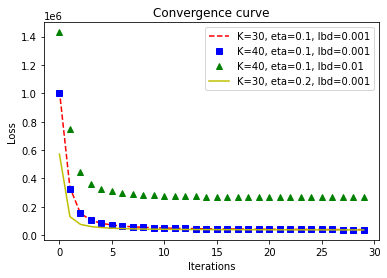

In [149]:
x = range(len(loss_k_30_eta_0_1_lbd_0_001))
plt.plot(x, loss_k_30_eta_0_1_lbd_0_001, 'r--',
         x, loss_k_40_eta_0_1_lbd_0_001, 'bs', 
         x, loss_k_40_eta_0_1_lbd_0_01, 'g^',
         x, loss_k_30_eta_0_2_lbd_0_001, 'y')
plt.title('Convergence curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(['K=30, eta=0.1, lbd=0.001', 'K=40, eta=0.1, lbd=0.001', 'K=40, eta=0.1, lbd=0.01', 'K=30, eta=0.2, lbd=0.001'])
plt.show()